In [63]:
# 导入drive模块并调用mount方法，将GoogleDrive挂载到Colab的文件系统中
# 挂载后，可以通过/content/drive目录访问Drive中的文件
from google.colab import drive
drive.mount('/content/drive')

# TODO：输入驱动器中保存解压缩文件的文件夹名
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# 将指定的文件夹添加到Python的模块搜索路径中，这样Colab可以加载该文件夹中的Python文件或模块
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# 下载CIFAR-10数据集
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# kNN分类器包括两个阶段：
- 在训练过程中，分类器获取训练数据并简单地记住它
- 在测试过程中，kNN通过与所有训练图像进行比较，并传递k个最相似训练样例的标签，对每个测试图像进行分类
- 对k的值进行交叉验证

在本练习中，您将实现这些步骤，了解基本的图像分类管道、交叉验证，并熟练编写高效的矢量化代码。

In [64]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# %matplotlib inline是一个魔法命令，使得Matplotlib生成的图像在Notebook中直接显示
# 而不是在新窗口中弹出
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置图像默认大小为10x8英寸
plt.rcParams['image.interpolation'] = 'nearest' # 设置图像插值方法为'nearest'，即最近邻插值
plt.rcParams['image.cmap'] = 'gray' # 设置图像的颜色映射为灰度

# 加载扩展，以便在修改外部 Python 模块后自动重新加载
# 设置自动重载模式为2，这意味着在执行代码时会自动重新加载所有外部模块
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
# 加载原始CIFAR-10数据
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# 清理变量以防止多次加载数据（这可能导致内存问题）
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 作为完整性检查，我们打印出训练和测试数据的大小
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


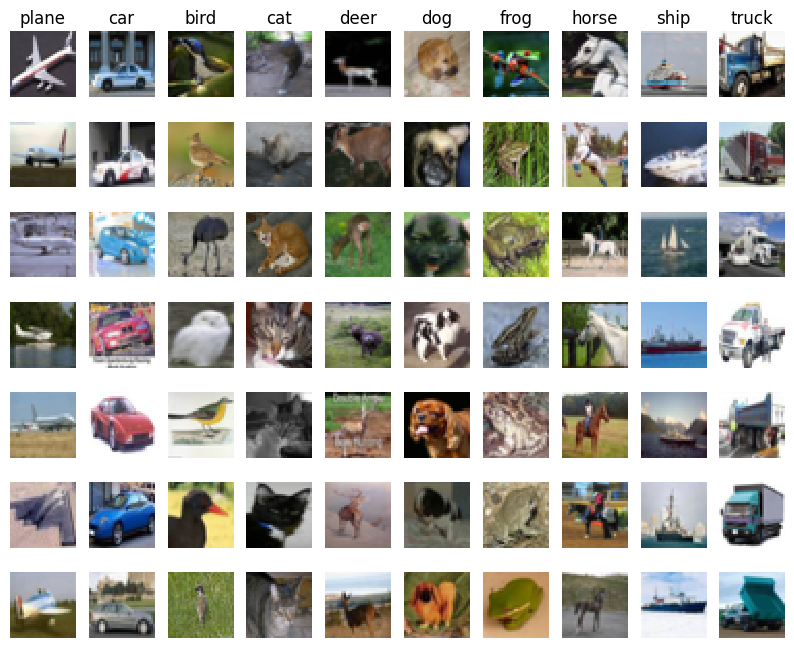

In [66]:
# 可视化数据集中的一些示例
# 我们从每个类中展示一些训练图像的例子
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [103]:
# 在这个练习中，为了更有效地执行代码，对数据进行子采样
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# 将图像数据重塑成行
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [68]:
from cs231n.classifiers import KNearestNeighbor

# 创建kNN分类器实例
# 记住，训练kNN分类器是无操作的
# 分类器只记住数据，不做进一步的处理
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

现在我们想用kNN分类器对测试数据进行分类。回想一下，我们可以把这个过程分成两个步骤：

1. 首先我们必须计算所有测试样例和所有训练样例之间的距离
2. 给定这些距离，对于每个测试示例，我们找到k个最接近的示例，并让它们为标签投票

让我们从计算所有训练样本和测试样本之间的距离矩阵开始。例如，如果有**Ntr**个训练样例和**Nte**个测试样例，这一阶段应该得到**Nte x Ntr**矩阵，其中每个元素（i,j）是第i个测试和第j个训练样例之间的距离。

**注意：对于我们要求您在本手册中实现的三个距离计算，不使用numpy提供的np.linalg.norm（）函数**

首先打开 `cs231n/classifiers/k_nearest_neighbor.py` 实现 `compute_distances_two_loops` 函数，该函数在所有（测试，训练）示例上使用（非常低效的）双循环，并一次计算一个元素的距离矩阵

In [69]:
# 打开cs231n/classifiers/k_nearest_neighbor.py
# 实现compute_distances_two_loops
# ！！以下测试请先完成k_nearest_neighbor.py中的compute_distances_two_loops函数！！

# 测试你的实现
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


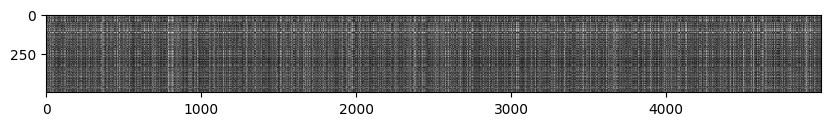

In [70]:
# 我们可以可视化距离矩阵：每一行是一个单独的测试样例和它到训练样例的距离
plt.imshow(dists, interpolation='none')
plt.show()

**问题1**

注意距离矩阵中的结构化模式，其中一些行或列明显更亮。（请注意，在默认配色方案中，黑色表示低距离，而白色表示高距离。）

- 数据中是什么原因导致了这些明显明亮的行？
- 是什么导致了这些列？

$\color{blue}{\textit Your Answer:}$

1. 测试集部分样本与训练集绝大多数样本的l2距离很远
2. 训练集部分样本与测试集中绝大部分样本的l2距离很远

In [71]:
# 现在实现函数predict_labels并运行下面的代码：
# 我们使用k=1（即最近邻）
y_test_pred = classifier.predict_labels(dists, k=1)

# 计算并打印正确预测示例的分数
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


应该期望看到大约“27%”的准确率。现在让我们尝试一个更大的k，比如k = 5：

In [72]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 145 / 500 correct => accuracy: 0.290000


应该期望看到比“k = 1”稍好的性能。事实也是如此。

**问题2**

我们还可以使用其他距离度量，如L1距离。对于某个图像$I_k$中位置$(i,j)$的像素值$p_{ij}^{(k)}$，

所有图像中所有像素的均值$\mu$定义为：
$$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
而所有图像中逐像素均值$\mu_{ij}$定义为：
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$

一般的标准差$\sigma$和逐像素标准差$\sigma_{ij}$的定义也类似。

以下哪种预处理步骤不会改变使用 L1 距离的最近邻分类器的性能？选择所有适用的选项。需要明确的是，训练样本和测试样本的预处理方式是相同的。

1. 减去均值 $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. 减去逐像素均值 $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. 减去均值 $\mu$ 并除以标准差 $\sigma$.
4. 减去逐像素均值 $\mu_{ij}$ 并除以逐像素标准差 $\sigma_{ij}$.
5. 旋转数据的坐标轴，即将所有图像按相同角度旋转。由于旋转而在图像中产生的空白区域用相同的像素值填充，不进行插值处理。

$\color{blue}{\textit Your Answer:}$ 有点点难度，以后有时间再来看这个


$\color{blue}{\textit Your Explanation:}$


In [73]:
# 现在让我们通过使用部分向量化和一个循环来加速距离矩阵的计算
# 实现函数compute_distances_one_loop并运行以下代码
dists_one = classifier.compute_distances_one_loop(X_test)

# 为了确保我们的向量化实现是正确的，我们需要确保它与简单实现一致。
# 有很多方法可以判断两个矩阵是否相似；其中一种最简单的方法是弗罗贝尼乌斯范数。
# 如果您之前没有见过，两个矩阵的弗罗贝尼乌斯范数是所有元素差值的平方和的平方根；
# 换句话说，就是将矩阵重塑为向量，然后计算它们之间的欧几里得距离。
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [74]:
# 现在在compute_distances_no_loops函数中实现完全矢量化的版本
dists_two = classifier.compute_distances_no_loops(X_test)

# 检查距离矩阵是否与我们之前计算的一致
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [75]:
# 让我们比较一下实现的速度
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# 使用完全矢量化的实现，您应该会看到明显更快的性能！
# 注意：根据您使用的机器，当您从两个循环到一个循环时，您可能不会看到加速，甚至可能会看到减速。

Two loop version took 38.954355 seconds
One loop version took 59.433442 seconds
No loop version took 0.621119 seconds


## 交叉验证
我们已经实现了k-最近邻分类器，但是我们任意地设置了k=5的值。现在我们将通过交叉验证来确定这个超参数的最佳值。

In [95]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
#########################################################################################
# TODO:
# 将训练数据分成折叠。
# 拆分之后，X_train_folds和y_train_folds应该都是长度为num_folds的列表
# 其中y_train_folds[i]是X_train_folds[i]中点的标签向量。
# 提示：查找numpy array_split函数。
#########################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
X_train_folds=np.array_split(X_train,num_folds)
y_train_folds=np.array_split(y_train,num_folds)
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# 一个字典，保存了我们在交叉验证时发现的不同k值的准确性.
# 在运行交叉验证之后，k_to_accuracies[k]应该是一个长度为num_folds的列表
# 给出我们在使用该k值时发现的不同精度值。

k_to_accuracies = {}


#####################################################################################################
# TODO:
# 执行k-fold交叉验证以找到k的最佳值。
# 对于k的每个可能值，运行k-近邻算法num_folds多次，
# 在每种情况下，除了一个折叠外，您使用所有折叠作为训练数据，最后一个折叠作为验证集。
# 将所有fold的精度和k的所有值存储在k_to_accuracies字典中。
#####################################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for k in k_choices:
  k_to_accuracies[k]=[]
  for i in range(num_folds):
    # 合并除测试集之外的折叠
    X_train=np.concatenate(X_train_folds[:i]+X_train_folds[i+1:])
    y_train=np.concatenate(y_train_folds[:i]+y_train_folds[i+1:])

    # 当前折叠作为测试集
    X_val=X_train_folds[i]
    y_val=y_train_folds[i]

    # 创建并训练KNN分类器
    nn=KNearestNeighbor()
    nn.train(X_train,y_train)

    # 使用验证集进行预测
    y_val_pred=nn.predict(X_val,k=k,num_loops=0)

    # 计算验证集的准确性
    accuracy=np.mean(y_val_pred==y_val)
    k_to_accuracies[k].append(accuracy)

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# 打印计算出的准确性
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.242188
k = 1, accuracy = 0.254688
k = 1, accuracy = 0.234375
k = 1, accuracy = 0.250000
k = 1, accuracy = 0.256250
k = 3, accuracy = 0.267188
k = 3, accuracy = 0.264062
k = 3, accuracy = 0.242188
k = 3, accuracy = 0.267188
k = 3, accuracy = 0.267188
k = 5, accuracy = 0.282813
k = 5, accuracy = 0.285938
k = 5, accuracy = 0.256250
k = 5, accuracy = 0.278125
k = 5, accuracy = 0.257812
k = 8, accuracy = 0.284375
k = 8, accuracy = 0.275000
k = 8, accuracy = 0.273438
k = 8, accuracy = 0.278125
k = 8, accuracy = 0.251563
k = 10, accuracy = 0.292187
k = 10, accuracy = 0.270313
k = 10, accuracy = 0.278125
k = 10, accuracy = 0.289062
k = 10, accuracy = 0.248438
k = 12, accuracy = 0.285938
k = 12, accuracy = 0.281250
k = 12, accuracy = 0.273438
k = 12, accuracy = 0.296875
k = 12, accuracy = 0.264062
k = 15, accuracy = 0.278125
k = 15, accuracy = 0.275000
k = 15, accuracy = 0.271875
k = 15, accuracy = 0.293750
k = 15, accuracy = 0.256250
k = 20, accuracy = 0.271875
k = 20, accu

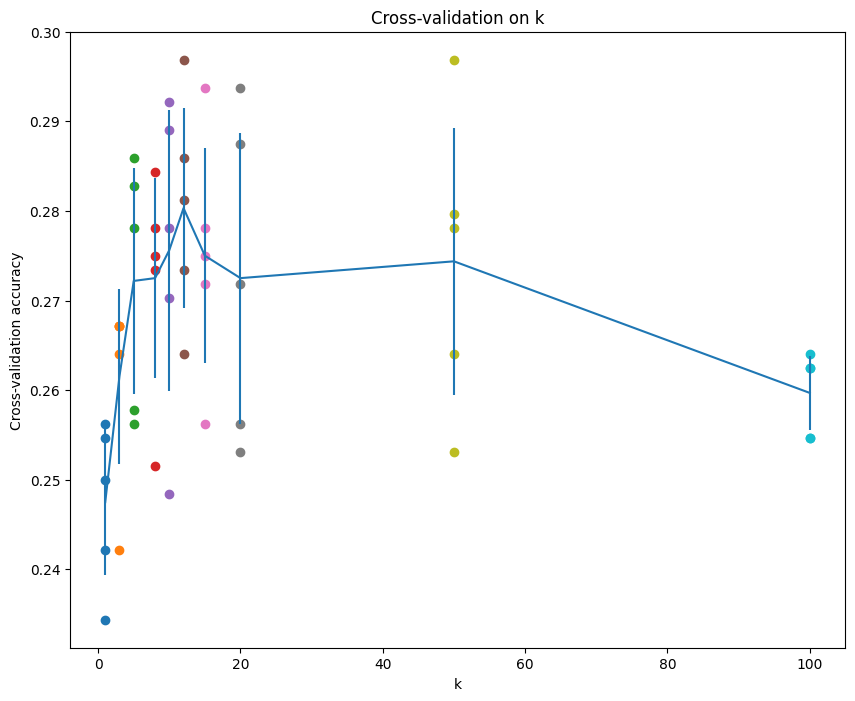

In [96]:
# 绘制原始观测结果
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# 用与标准差对应的误差条绘制趋势线
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [104]:
# 根据上述交叉验证结果，选择k的最佳值，
# 使用所有训练数据重新训练分类器，并在测试数据上进行测试。
# 您应该能够在测试数据上获得28%以上的准确性。
best_k = 12

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# 计算并显示精度
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 133 / 500 correct => accuracy: 0.266000


**问题3**

下面哪个关于 ($k$-NN) 的陈述在分类设置中是正确的，并且对所有的 $k$ 都是正确的？
1. k-NN分类器的决策边界是线性的。
2. 1-NN的训练误差总是小于或等于5-NN的训练误差。
3. 1-NN的测试误差总是小于5-NN的测试误差。
4. 使用k-NN分类器对测试样例进行分类所需的时间随着训练集的大小而增长。
5. 以上都不是

$\color{blue}{\textit Your Answer:}$
4


$\color{blue}{\textit Your Explanation:}$

